In [892]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import requests

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 20)

## Fetch Data

### Standing

In [1138]:
standings_ulrs = {
    "SerieA": "http://api.football-data.org/v4/competitions/SA/standings",
    "Bundesliga": "http://api.football-data.org/v4/competitions/BL1/standings",
    "La Liga": "http://api.football-data.org/v4/competitions/PD/standings"
}
headers = {"X-Auth-Token": ""}

In [1385]:
standings = {}

for competition, url in standings_dict.items():
    response = requests.get(url, headers=headers)

    data = response.json()
    data = data['standings'][0]['table']
    standing = pd.DataFrame(data)

    # Extract the 'shortName' value from the 'team' dictionary
    standing['team_short_name'] = standing['team'].apply(lambda x: x['shortName'])
    # Drop the 'team' column
    standing.drop(columns=['team'], inplace=True)
    
    n_groups = 3
    standing['team_group'] = standing.position.apply(lambda x: int(((x-1)/(20/n_groups))))
    standing['team_short_name'] = standing['team_short_name'].replace({
                                                                'Spezia Calcio':'Spezia',
                                                                #
                                                                'Frankfurt':'Ein Frankfurt', 
                                                                '1. FC Köln': 'FC Koln',
                                                                'Hertha BSC': 'Hertha', 
                                                                'Bremen': 'Werder Bremen', 
                                                                'Schalke': 'Schalke 04', 
                                                                'Bayern': 'Bayern Munich',
                                                                #
                                                                'Barça':'Barcelona', 
                                                                'Cádiz CF': 'Cadiz', 
                                                                'Almería': 'Almeria', 
                                                                'Athletic':'Ath Bilbao', 
                                                                'Real Betis': 'Betis', 
                                                                'Espanyol': 'Espanol',
                                                                'Sevilla FC': 'Sevilla',
                                                                'Atleti': 'Ath Madrid', 
                                                                'Real Sociedad':'Sociedad', 
                                                                'Rayo Vallecano': 'Vallecano'
                                                                })

    standings[competition] = standing

### Results

In [1386]:
data_url = {
    "Serie A": "https://www.football-data.co.uk/mmz4281/2223/I1.csv",
    "Bundesliga": "https://www.football-data.co.uk/mmz4281/2223/D1.csv",
    "La Liga": "https://www.football-data.co.uk/mmz4281/2223/SP1.csv"
}

data_paths = {
}

for competition, url in data_url.items():
    response = requests.get(url)
    filename = competition.replace(' ','_') + "_2022_2023.csv"
    file_path = f'data/raw/{filename}'

    with open(file_path, "wb") as f:
        f.write(response.content)
        
    df = pd.read_csv(file_path)
    df.loc[(df.HomeTeam == 'Empoli') & (df.AwayTeam == 'Cremonese'),'Date'] = '12/11/2022'
    df['year'] = pd.to_datetime(df.Date, format='%d/%m/%Y').dt.year
    df['month'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.month
    df['day'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.day
    df['week'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.isocalendar().week
    df['weekday'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.weekday
    
    df = df.sort_values(['year', 'month', 'day'])

    # Assign sequential week numbers to blocks of days from Thursday to Wednesday
    giornata = 1
    curr_day = (2020,1,1,-1,-1)
    infrasettimanale = False
    for i, row in df.iterrows():
        if row['week'] != curr_day[3] and abs(curr_day[4] - row['weekday']) < 6 and curr_day[4] > -1: 
            giornata += 1
        if row['week'] == curr_day[3] and abs(curr_day[4] - row['weekday']) > 1: 
            giornata += 1
        curr_day = (row['year'], row['month'], row['day'], row['week'], row['weekday'])
        df.at[i, 'giornata'] = giornata
    
    df.to_csv(f"data/clean/{filename}", index=False)
    data_paths[competition] = f"data/clean/{filename}"

## Configuration

In [1389]:
competition = 'Bundesliga'
home_team = 'Bayern Munich'
away_team = 'Dortmund'

In [1390]:
df = pd.read_csv(data_paths[competition], index_col=None)
df

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,year,month,day,week,weekday,giornata
0,D1,05/08/2022,19:30,Ein Frankfurt,Bayern Munich,1,6,A,0,5,...,2.01,2.00,1.93,1.94,2022,8,5,31,4,1.0
1,D1,06/08/2022,14:30,Augsburg,Freiburg,0,4,A,0,0,...,2.08,1.89,2.03,1.84,2022,8,6,31,5,1.0
2,D1,06/08/2022,14:30,Bochum,Mainz,1,2,A,1,1,...,1.99,1.99,1.93,1.93,2022,8,6,31,5,1.0
3,D1,06/08/2022,14:30,M'gladbach,Hoffenheim,3,1,H,1,1,...,2.10,1.88,2.04,1.84,2022,8,6,31,5,1.0
4,D1,06/08/2022,14:30,Union Berlin,Hertha,3,1,H,1,0,...,1.93,2.05,1.88,1.99,2022,8,6,31,5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,D1,01/04/2023,14:30,Union Berlin,Stuttgart,3,0,H,0,0,...,1.89,2.15,1.81,2.06,2023,4,1,13,5,26.0
230,D1,01/04/2023,14:30,Wolfsburg,Augsburg,2,2,D,0,2,...,2.01,1.96,1.95,1.91,2023,4,1,13,5,26.0
231,D1,01/04/2023,17:30,Bayern Munich,Dortmund,4,2,H,3,0,...,2.08,1.93,2.00,1.86,2023,4,1,13,5,26.0
232,D1,02/04/2023,14:30,FC Koln,M'gladbach,0,0,D,0,0,...,1.99,2.01,1.92,1.93,2023,4,2,13,6,26.0


In [1405]:
tt = df.merge(standing, left_on='HomeTeam', right_on='team_short_name', how='left')
assert len(tt[tt.team_group.isna()]) == 0, 'Some teams have no correpondence in standing'

In [1392]:
standing = standings[competition]
standing

,position,playedGames,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
0,1,26,"W,L,W,W,W",16,7,3,55,76,29,47,Bayern Munich,0
1,2,26,"L,W,D,W,W",17,2,7,53,57,35,22,Dortmund,0
2,3,26,"W,W,D,D,L",15,6,5,51,41,28,13,Union Berlin,0
3,4,26,"D,D,W,D,D",13,8,5,47,39,35,4,Freiburg,0
4,5,26,"L,L,W,L,W",13,6,7,45,49,33,16,RB Leipzig,0
5,6,26,"D,L,D,D,L",11,8,7,41,47,37,10,Ein Frankfurt,0
6,7,26,"W,W,W,W,D",12,4,10,40,48,40,8,Leverkusen,0
7,8,26,"W,D,D,W,W",11,7,8,40,43,36,7,Mainz,1
8,9,26,"D,W,D,D,W",10,9,7,39,46,34,12,Wolfsburg,1
9,10,26,"D,D,L,D,L",8,8,10,32,40,44,-4,M'gladbach,1


## Data Preparations

In [1393]:
df_match_home = df
df_match_home['main_team'] = df.HomeTeam
df_match_home['opponent_team'] = df.AwayTeam
df_match_home['goal_fatti'] = df['FTHG']
df_match_home['goal_subiti'] = df['FTAG']
df_match_home['tot_goals'] = df['goal_fatti'] + df['goal_subiti']
df_match_home['no_goal'] = (df['goal_fatti'] == 0) | (df['goal_subiti'] == 0)
df_match_home['goal'] = (df['goal_fatti'] != 0) & (df['goal_subiti'] != 0)
df_match_home['goal_no_goal'] = df_match_home['no_goal'].map({True: 'No Goal', False: 'Goal'})
df_match_home['type'] = 'home'
df_match_home['result'] = df_match_home.apply(get_result, axis=1)
df_match_home['team_has_scored'] = df_match_home['goal_fatti'] > 0
df_match_home = df_match_home[['main_team','opponent_team','goal_fatti', 'no_goal', 'goal', 'tot_goals',\
                               'goal_subiti','type','result','team_has_scored','giornata','goal_no_goal']]

df_match_away = df
df_match_away['main_team'] = df.AwayTeam
df_match_away['opponent_team'] = df.HomeTeam
df_match_away['goal_fatti'] = df['FTAG']
df_match_away['goal_subiti'] = df['FTHG']
df_match_away['tot_goals'] = df['goal_fatti'] + df['goal_subiti']
df_match_away['type'] = 'away'
df_match_away['result'] = df_match_away.apply(get_result, axis=1)
df_match_away['team_has_scored'] = df_match_away['goal_fatti'] > 0
df_match_away['no_goal'] = (df['goal_fatti'] == 0) | (df['goal_subiti'] == 0)
df_match_away['goal'] = (df['goal_fatti'] != 0) & (df['goal_subiti'] != 0)
df_match_away['goal_no_goal'] = df_match_away['no_goal'].map({True: 'No Goal', False: 'Goal'})
df_match_away = df_match_away[['main_team','opponent_team','goal_fatti', 'no_goal', 'goal', 'tot_goals',\
                               'goal_subiti','type','result','team_has_scored','giornata','goal_no_goal']]
df_match = pd.concat([df_match_home, df_match_away])
df_match

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal
0,Ein Frankfurt,Bayern Munich,1,False,True,7,6,home,Loss,True,1.0,Goal
1,Augsburg,Freiburg,0,True,False,4,4,home,Loss,False,1.0,No Goal
2,Bochum,Mainz,1,False,True,3,2,home,Loss,True,1.0,Goal
3,M'gladbach,Hoffenheim,3,False,True,4,1,home,Win,True,1.0,Goal
4,Union Berlin,Hertha,3,False,True,4,1,home,Win,True,1.0,Goal
...,...,...,...,...,...,...,...,...,...,...,...,...
229,Stuttgart,Union Berlin,0,True,False,3,3,away,Loss,False,26.0,No Goal
230,Augsburg,Wolfsburg,2,False,True,4,2,away,Draw,True,26.0,Goal
231,Dortmund,Bayern Munich,2,False,True,6,4,away,Loss,True,26.0,Goal
232,M'gladbach,FC Koln,0,True,False,0,0,away,Draw,False,26.0,No Goal


In [1394]:
df_match.main_team.unique()

array(['Ein Frankfurt', 'Augsburg', 'Bochum', "M'gladbach",
       'Union Berlin', 'Wolfsburg', 'Dortmund', 'Stuttgart', 'FC Koln',
       'Freiburg', 'Hertha', 'Hoffenheim', 'Leverkusen', 'RB Leipzig',
       'Werder Bremen', 'Schalke 04', 'Mainz', 'Bayern Munich'],
      dtype=object)

## Analysis

### Plot number goals over giornate

<Axes: xlabel='giornata'>

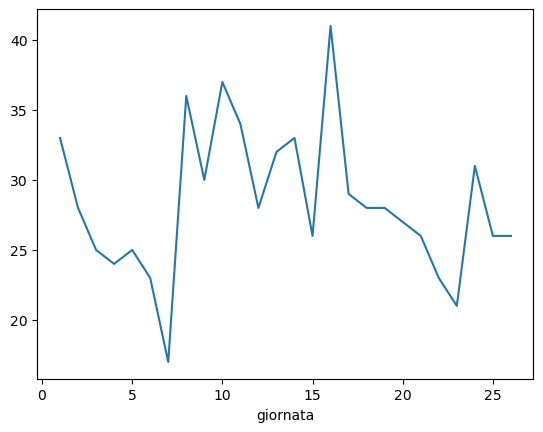

In [1342]:
df[['giornata','tot_goals']].groupby(['giornata']).sum().tot_goals.plot()

### Goals distribution over matches in each giornata

In [1343]:
df['row_num'] = df.groupby('giornata').cumcount()
boxgoals = df[['giornata','row_num','tot_goals']].pivot(index='row_num', columns='giornata', values='tot_goals')

<Axes: >

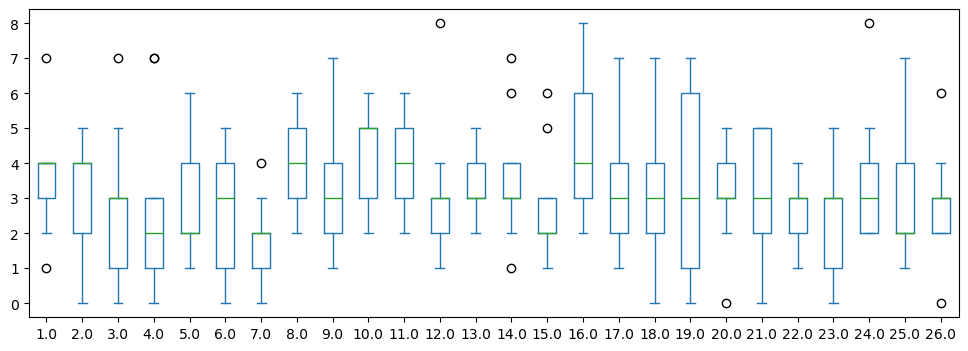

In [1344]:
boxgoals.plot(kind='box', figsize=(12,4))

### Under/Over

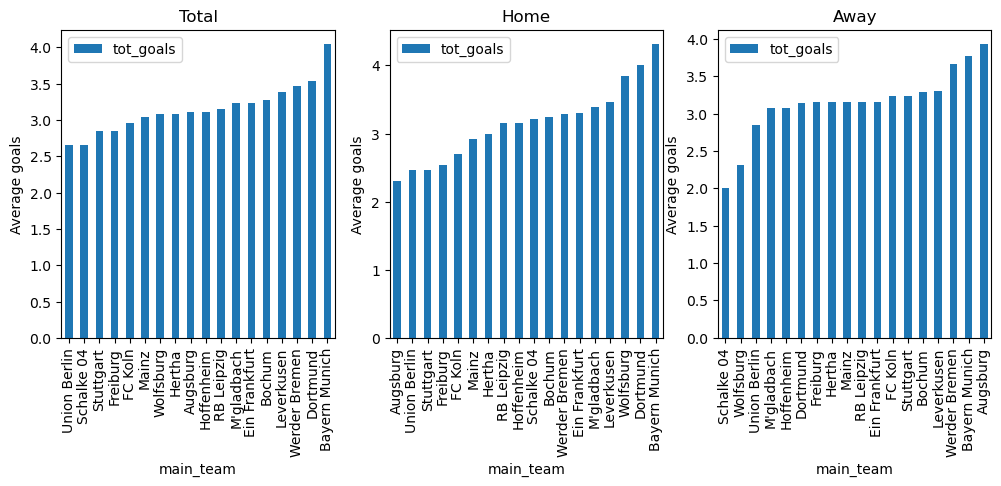

In [1345]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_match[['main_team', 'tot_goals']].groupby('main_team').mean().sort_values('tot_goals').plot(kind='bar',  ax=ax[0])
df_match[df_match.type=='home'][['main_team', 'tot_goals']].groupby('main_team').mean().sort_values('tot_goals').plot(kind='bar',  ax=ax[1])
df_match[df_match.type=='away'][['main_team', 'tot_goals']].groupby('main_team').mean().sort_values('tot_goals').plot(kind='bar',  ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Home')
ax[2].set_title('Away')
ax[0].set_ylabel('Average goals')
ax[1].set_ylabel('Average goals')
ax[2].set_ylabel('Average goals')

plt.show()

### Goal/No Goal

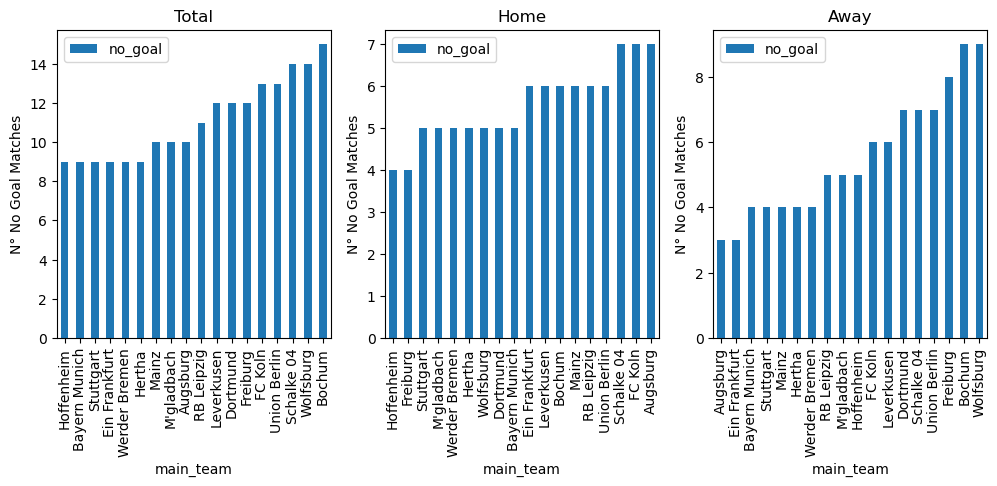

In [1346]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_match[['main_team','no_goal']].groupby('main_team').sum().sort_values('no_goal').plot(kind='bar',  ax=ax[0])
df_match[df_match.type=='home'][['main_team','no_goal']].groupby('main_team').sum().sort_values('no_goal').plot(kind='bar',  ax=ax[1])
df_match[df_match.type=='away'][['main_team','no_goal']].groupby('main_team').sum().sort_values('no_goal').plot(kind='bar',  ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Home')
ax[2].set_title('Away')
ax[0].set_ylabel('N° No Goal Matches')
ax[1].set_ylabel('N° No Goal Matches')
ax[2].set_ylabel('N° No Goal Matches')

plt.show()

In [1347]:
df_match[(df_match.main_team == 'Real Madrid') & (df_match.type=='home')]

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal


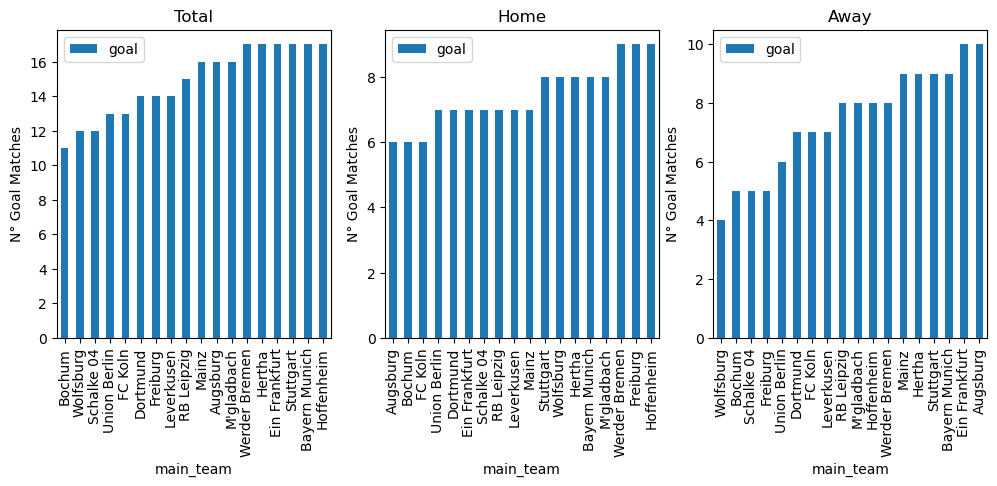

In [1348]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_match[['main_team','goal']].groupby('main_team').sum().sort_values('goal').plot(kind='bar',  ax=ax[0])
df_match[df_match.type=='home'][['main_team','goal']].groupby('main_team').sum().sort_values('goal').plot(kind='bar',  ax=ax[1])
df_match[df_match.type=='away'][['main_team','goal']].groupby('main_team').sum().sort_values('goal').plot(kind='bar',  ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Home')
ax[2].set_title('Away')
ax[0].set_ylabel('N° Goal Matches')
ax[1].set_ylabel('N° Goal Matches')
ax[2].set_ylabel('N° Goal Matches')

plt.show()

## Match analysis

In [1349]:
df['no_goal'] = (df.FTHG == 0) | (df.FTAG == 0)
df['goal'] = (df.FTHG != 0) & (df.FTAG != 0)
df['tot_goals'] = df.FTHG + df.FTAG

In [1350]:
def get_result(row):
    if(row['goal_fatti'] > row['goal_subiti']):
        return 'Win'
    if(row['goal_fatti'] == row['goal_subiti']):
        return 'Draw'
    return 'Loss'

In [1351]:
df_match_home = df
df_match_home['main_team'] = df.HomeTeam
df_match_home['opponent_team'] = df.AwayTeam
df_match_home['goal_fatti'] = df['FTHG']
df_match_home['goal_subiti'] = df['FTAG']
df_match_home['tot_goals'] = df['goal_fatti'] + df['goal_subiti']
df_match_home['no_goal'] = (df['goal_fatti'] == 0) | (df['goal_subiti'] == 0)
df_match_home['goal_no_goal'] = df_match_home['no_goal'].map({True: 'No Goal', False: 'Goal'})
df_match_home['type'] = 'home'
df_match_home['result'] = df_match_home.apply(get_result, axis=1)
df_match_home['team_has_scored'] = df_match_home['goal_fatti'] > 0
df_match_home = df_match_home[['main_team','opponent_team','goal_fatti', 'no_goal','tot_goals',\
                               'goal_subiti','type','result','team_has_scored','giornata','goal_no_goal']]

df_match_away = df
df_match_away['main_team'] = df.AwayTeam
df_match_away['opponent_team'] = df.HomeTeam
df_match_away['goal_fatti'] = df['FTAG']
df_match_away['goal_subiti'] = df['FTHG']
df_match_away['tot_goals'] = df['goal_fatti'] + df['goal_subiti']
df_match_away['type'] = 'away'
df_match_away['result'] = df_match_away.apply(get_result, axis=1)
df_match_away['team_has_scored'] = df_match_away['goal_fatti'] > 0
df_match_away['no_goal'] = (df['goal_fatti'] == 0) | (df['goal_subiti'] == 0)
df_match_home['goal_no_goal'] = df_match_home['no_goal'].map({True: 'No Goal', False: 'Goal'})
df_match_away = df_match_away[['main_team','opponent_team','goal_fatti', 'no_goal','tot_goals',\
                               'goal_subiti','type','result','team_has_scored','giornata','goal_no_goal']]
df_match = pd.concat([df_match_home, df_match_away])
df_match

,main_team,opponent_team,goal_fatti,no_goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal
0,Ein Frankfurt,Bayern Munich,1,False,7,6,home,Loss,True,1.0,Goal
1,Augsburg,Freiburg,0,True,4,4,home,Loss,False,1.0,No Goal
2,Bochum,Mainz,1,False,3,2,home,Loss,True,1.0,Goal
3,M'gladbach,Hoffenheim,3,False,4,1,home,Win,True,1.0,Goal
4,Union Berlin,Hertha,3,False,4,1,home,Win,True,1.0,Goal
...,...,...,...,...,...,...,...,...,...,...,...
229,Stuttgart,Union Berlin,0,True,3,3,away,Loss,False,26.0,No Goal
230,Augsburg,Wolfsburg,2,False,4,2,away,Draw,True,26.0,Goal
231,Dortmund,Bayern Munich,2,False,6,4,away,Loss,True,26.0,Goal
232,M'gladbach,FC Koln,0,True,0,0,away,Draw,False,26.0,No Goal


#### Home Team

In [1352]:
team_home_df = df_match[(df_match.main_team==home_team)]
team_home_df

,main_team,opponent_team,goal_fatti,no_goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal
17,Bayern Munich,Wolfsburg,2,True,2,0,home,Win,True,2.0,No Goal
33,Bayern Munich,M'gladbach,1,False,2,1,home,Draw,True,4.0,Goal
46,Bayern Munich,Stuttgart,2,False,4,2,home,Draw,True,6.0,Goal
63,Bayern Munich,Leverkusen,4,True,4,0,home,Win,True,8.0,No Goal
89,Bayern Munich,Freiburg,5,True,5,0,home,Win,True,10.0,No Goal
...,...,...,...,...,...,...,...,...,...,...,...
135,Bayern Munich,RB Leipzig,1,False,2,1,away,Draw,True,16.0,Goal
170,Bayern Munich,Wolfsburg,4,False,6,2,away,Win,True,19.0,Goal
182,Bayern Munich,M'gladbach,2,False,5,3,away,Loss,True,21.0,Goal
204,Bayern Munich,Stuttgart,2,False,3,1,away,Win,True,23.0,Goal


In [1353]:
df_match.sort_values('giornata').head(20)

,main_team,opponent_team,goal_fatti,no_goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal
0,Ein Frankfurt,Bayern Munich,1,False,7,6,home,Loss,True,1.0,Goal
2,Mainz,Bochum,2,False,3,1,away,Win,True,1.0,Goal
3,Hoffenheim,M'gladbach,1,False,4,3,away,Loss,True,1.0,Goal
4,Hertha,Union Berlin,1,False,4,3,away,Loss,True,1.0,Goal
5,Werder Bremen,Wolfsburg,2,False,4,2,away,Draw,True,1.0,Goal
6,Leverkusen,Dortmund,0,True,1,1,away,Loss,False,1.0,No Goal
7,RB Leipzig,Stuttgart,1,False,2,1,away,Draw,True,1.0,Goal
8,Schalke 04,FC Koln,1,False,4,3,away,Loss,True,1.0,Goal
1,Freiburg,Augsburg,4,True,4,0,away,Win,True,1.0,No Goal
0,Bayern Munich,Ein Frankfurt,6,False,7,1,away,Win,True,1.0,Goal


In [1354]:
team_home_df_grp = team_home_df.merge(standing, left_on='opponent_team', right_on='team_short_name')
team_home_df_grp = team_home_df_grp[team_home_df_grp.team_group == standing[standing['team_short_name']==away_team].team_group.max()]

##### Goal/No Goal

In [1355]:
team_home_df_grp[team_home_df_grp.type=='home']

,main_team,opponent_team,goal_fatti,no_goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
6,Bayern Munich,Leverkusen,4,True,4,0,home,Win,True,8.0,...,"W,W,W,W,D",12,4,10,40,48,40,8,Leverkusen,0
8,Bayern Munich,Freiburg,5,True,5,0,home,Win,True,10.0,...,"D,D,W,D,D",13,8,5,47,39,35,4,Freiburg,0
12,Bayern Munich,Ein Frankfurt,1,False,2,1,home,Draw,True,18.0,...,"D,L,D,D,L",11,8,7,41,47,37,10,Ein Frankfurt,0
16,Bayern Munich,Union Berlin,3,True,3,0,home,Win,True,22.0,...,"W,W,D,D,L",15,6,5,51,41,28,13,Union Berlin,0
20,Bayern Munich,Dortmund,4,False,6,2,home,Win,True,26.0,...,"L,W,D,W,W",17,2,7,53,57,35,22,Dortmund,0


In [1356]:
df_match[['main_team','goal_no_goal']].groupby('main_team').value_counts()\
                                      .reset_index().pivot(columns='main_team', values=0, index='goal_no_goal')\
                                      .to_csv('outputs/goal_no_goal.csv')

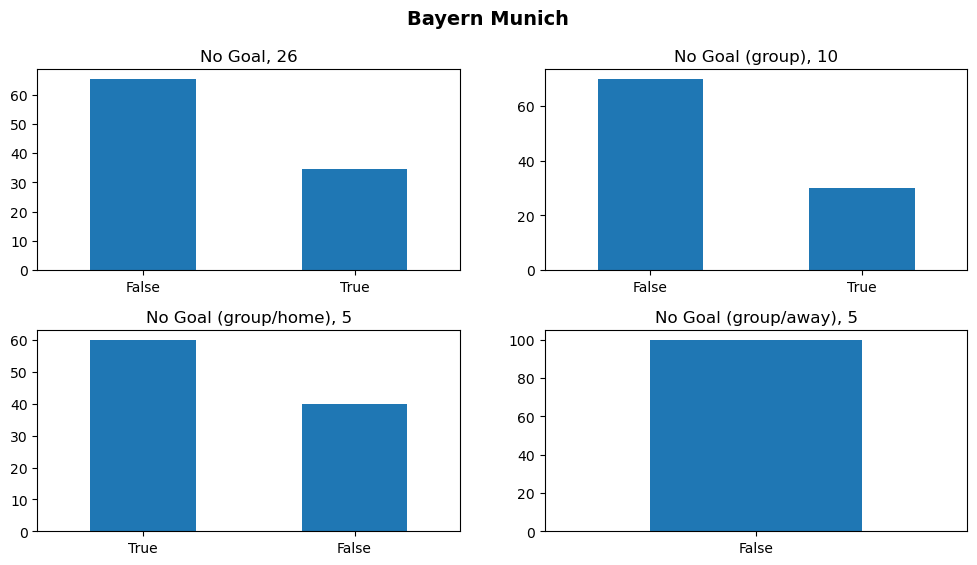

In [1357]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle(f"{home_team}", fontsize=14, fontweight='bold')

(team_home_df.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal, {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### N° Goals

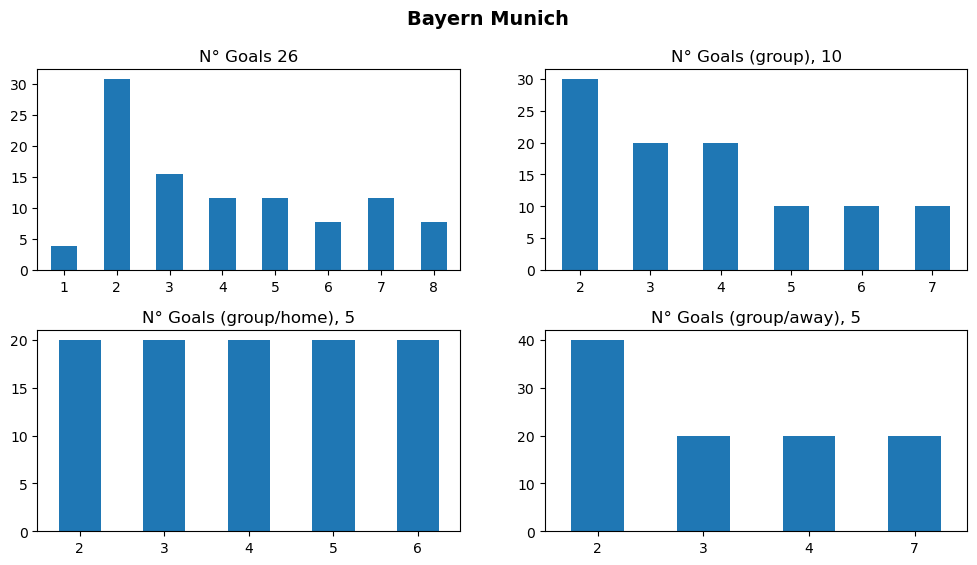

In [1358]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle(f"{home_team}", fontsize=14, fontweight='bold')

(team_home_df['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Has scored

<Axes: title={'center': 'Has scored (gpr/away), 5'}>

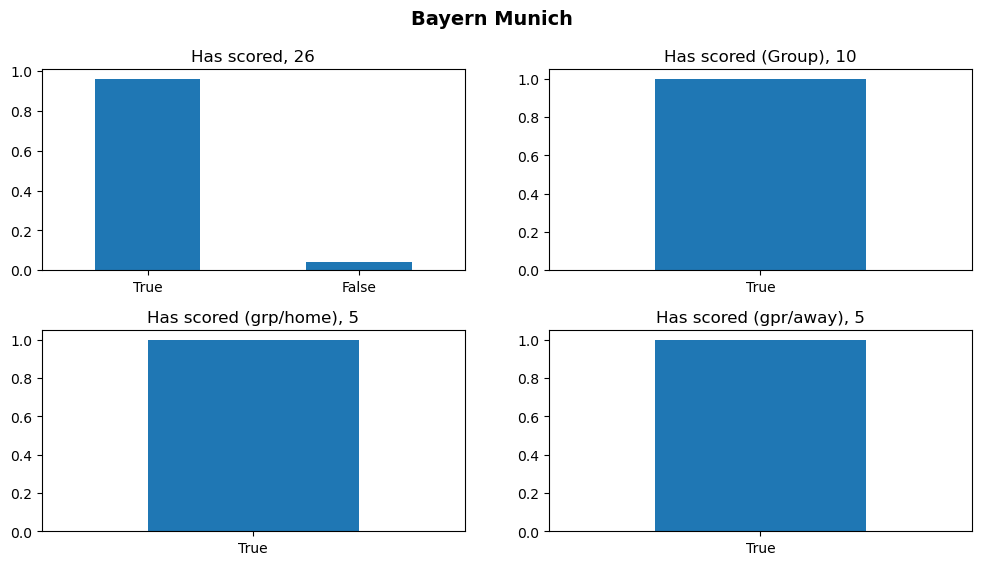

In [1359]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle(f"{home_team}", fontsize=14, fontweight='bold')

team_home_df.team_has_scored.value_counts(normalize=True).plot(kind='bar', rot=0, title=f'Has scored, {len(team_home_df)}', ax=axes[0][0])
team_home_df_grp.team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', rot=0, title=f'Has scored (Group), {len(team_home_df_grp)}', ax=axes[0][1])
team_home_df_grp[team_home_df_grp.type=='home'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', rot=0, title=f'Has scored (grp/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0])
team_home_df_grp[team_home_df_grp.type=='away'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', rot=0, title=f'Has scored (gpr/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1])


In [1360]:
team_home_df_grp

,main_team,opponent_team,goal_fatti,no_goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
6,Bayern Munich,Leverkusen,4,True,4,0,home,Win,True,8.0,...,"W,W,W,W,D",12,4,10,40,48,40,8,Leverkusen,0
7,Bayern Munich,Leverkusen,1,False,3,2,away,Loss,True,25.0,...,"W,W,W,W,D",12,4,10,40,48,40,8,Leverkusen,0
8,Bayern Munich,Freiburg,5,True,5,0,home,Win,True,10.0,...,"D,D,W,D,D",13,8,5,47,39,35,4,Freiburg,0
12,Bayern Munich,Ein Frankfurt,1,False,2,1,home,Draw,True,18.0,...,"D,L,D,D,L",11,8,7,41,47,37,10,Ein Frankfurt,0
13,Bayern Munich,Ein Frankfurt,6,False,7,1,away,Win,True,1.0,...,"D,L,D,D,L",11,8,7,41,47,37,10,Ein Frankfurt,0
16,Bayern Munich,Union Berlin,3,True,3,0,home,Win,True,22.0,...,"W,W,D,D,L",15,6,5,51,41,28,13,Union Berlin,0
17,Bayern Munich,Union Berlin,1,False,2,1,away,Draw,True,5.0,...,"W,W,D,D,L",15,6,5,51,41,28,13,Union Berlin,0
20,Bayern Munich,Dortmund,4,False,6,2,home,Win,True,26.0,...,"L,W,D,W,W",17,2,7,53,57,35,22,Dortmund,0
21,Bayern Munich,Dortmund,2,False,4,2,away,Draw,True,9.0,...,"L,W,D,W,W",17,2,7,53,57,35,22,Dortmund,0
25,Bayern Munich,RB Leipzig,1,False,2,1,away,Draw,True,16.0,...,"L,L,W,L,W",13,6,7,45,49,33,16,RB Leipzig,0


##### Results

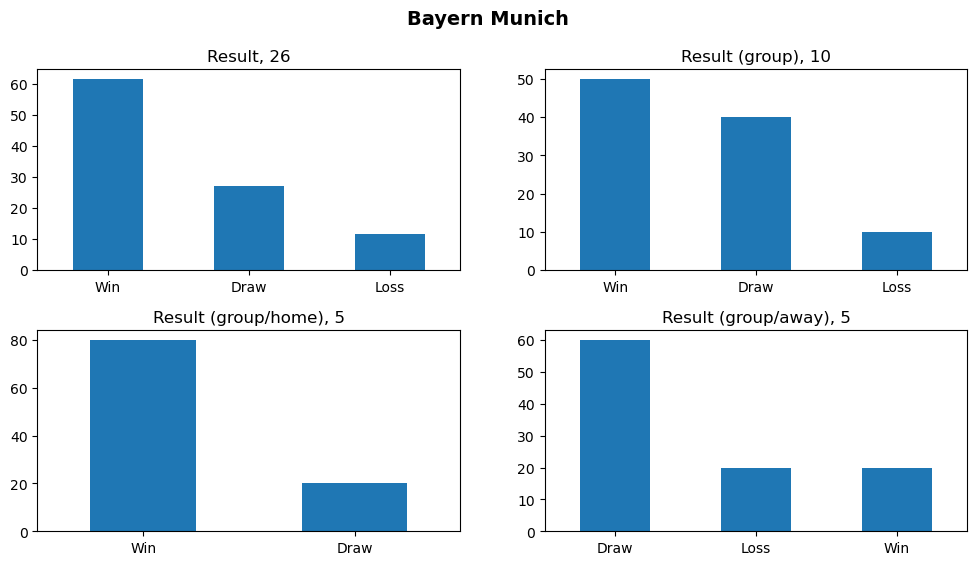

In [1361]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle(f"{home_team}", fontsize=14, fontweight='bold')

(team_home_df.result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result, {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp.result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home'].result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away'].result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

In [1362]:
team_home_df_grp

,main_team,opponent_team,goal_fatti,no_goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
6,Bayern Munich,Leverkusen,4,True,4,0,home,Win,True,8.0,...,"W,W,W,W,D",12,4,10,40,48,40,8,Leverkusen,0
7,Bayern Munich,Leverkusen,1,False,3,2,away,Loss,True,25.0,...,"W,W,W,W,D",12,4,10,40,48,40,8,Leverkusen,0
8,Bayern Munich,Freiburg,5,True,5,0,home,Win,True,10.0,...,"D,D,W,D,D",13,8,5,47,39,35,4,Freiburg,0
12,Bayern Munich,Ein Frankfurt,1,False,2,1,home,Draw,True,18.0,...,"D,L,D,D,L",11,8,7,41,47,37,10,Ein Frankfurt,0
13,Bayern Munich,Ein Frankfurt,6,False,7,1,away,Win,True,1.0,...,"D,L,D,D,L",11,8,7,41,47,37,10,Ein Frankfurt,0
16,Bayern Munich,Union Berlin,3,True,3,0,home,Win,True,22.0,...,"W,W,D,D,L",15,6,5,51,41,28,13,Union Berlin,0
17,Bayern Munich,Union Berlin,1,False,2,1,away,Draw,True,5.0,...,"W,W,D,D,L",15,6,5,51,41,28,13,Union Berlin,0
20,Bayern Munich,Dortmund,4,False,6,2,home,Win,True,26.0,...,"L,W,D,W,W",17,2,7,53,57,35,22,Dortmund,0
21,Bayern Munich,Dortmund,2,False,4,2,away,Draw,True,9.0,...,"L,W,D,W,W",17,2,7,53,57,35,22,Dortmund,0
25,Bayern Munich,RB Leipzig,1,False,2,1,away,Draw,True,16.0,...,"L,L,W,L,W",13,6,7,45,49,33,16,RB Leipzig,0


##### Result Trend

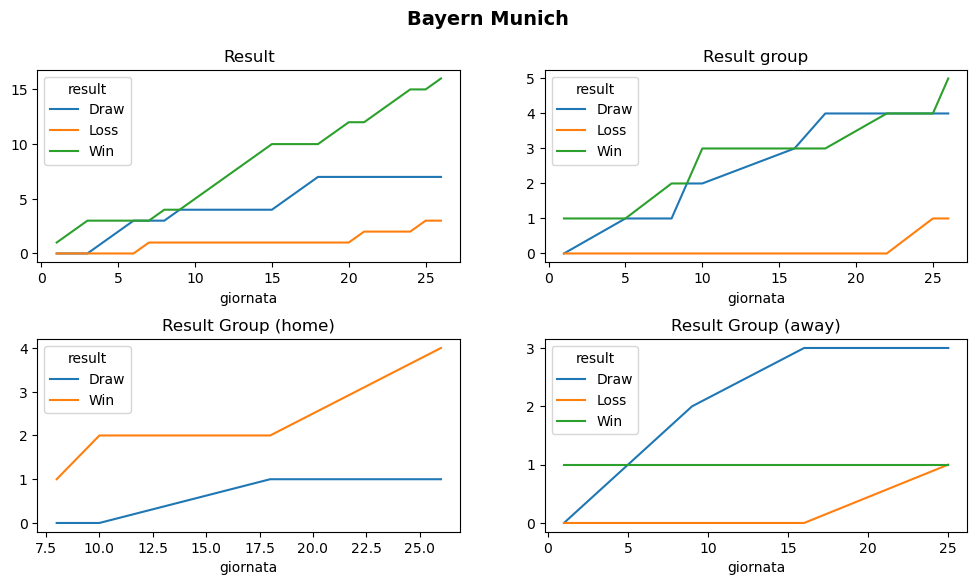

In [1363]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"{home_team}", fontsize=14, fontweight='bold')

team_home_df_grp['value'] = 1
team_home_df['value'] = 1
team_home_df[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result", ax=axes[0][0], rot=0)
team_home_df_grp[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result group", ax=axes[0][1], rot=0)
team_home_df_grp[team_home_df_grp.type=='home'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (home)", ax=axes[1][0], rot=0)
team_home_df_grp[team_home_df_grp.type=='away'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (away)", ax=axes[1][1], rot=0)
plt.show()

In [1364]:
team_home_df['team_has_scored'] = team_home_df['goal_fatti'] > 0

In [1365]:
team_home_df

,main_team,opponent_team,goal_fatti,no_goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,value
17,Bayern Munich,Wolfsburg,2,True,2,0,home,Win,True,2.0,No Goal,1
33,Bayern Munich,M'gladbach,1,False,2,1,home,Draw,True,4.0,Goal,1
46,Bayern Munich,Stuttgart,2,False,4,2,home,Draw,True,6.0,Goal,1
63,Bayern Munich,Leverkusen,4,True,4,0,home,Win,True,8.0,No Goal,1
89,Bayern Munich,Freiburg,5,True,5,0,home,Win,True,10.0,No Goal,1
...,...,...,...,...,...,...,...,...,...,...,...,...
135,Bayern Munich,RB Leipzig,1,False,2,1,away,Draw,True,16.0,Goal,1
170,Bayern Munich,Wolfsburg,4,False,6,2,away,Win,True,19.0,Goal,1
182,Bayern Munich,M'gladbach,2,False,5,3,away,Loss,True,21.0,Goal,1
204,Bayern Munich,Stuttgart,2,False,3,1,away,Win,True,23.0,Goal,1


#### Away Team

In [1366]:
team_away_df = df_match[(df_match.main_team==away_team)]
team_away_df

,main_team,opponent_team,goal_fatti,no_goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal
6,Dortmund,Leverkusen,1,True,1,0,home,Win,True,1.0,No Goal
20,Dortmund,Werder Bremen,2,False,5,3,home,Loss,True,3.0,Goal
36,Dortmund,Hoffenheim,1,True,1,0,home,Win,True,5.0,No Goal
56,Dortmund,Schalke 04,1,True,1,0,home,Win,True,7.0,No Goal
77,Dortmund,Bayern Munich,2,False,4,2,home,Draw,True,9.0,Goal
...,...,...,...,...,...,...,...,...,...,...,...
161,Dortmund,Leverkusen,2,True,2,0,away,Win,True,18.0,No Goal
176,Dortmund,Werder Bremen,2,True,2,0,away,Win,True,20.0,No Goal
192,Dortmund,Hoffenheim,1,True,1,0,away,Win,True,22.0,No Goal
212,Dortmund,Schalke 04,2,False,4,2,away,Draw,True,24.0,Goal


In [1367]:
team_away_df_grp = team_away_df.merge(standing, left_on='opponent_team', right_on='team_short_name')
team_away_df_grp = team_away_df_grp[team_away_df_grp.team_group == standing[standing['team_short_name']==home_team].team_group.max()]

##### Goal/No Goal

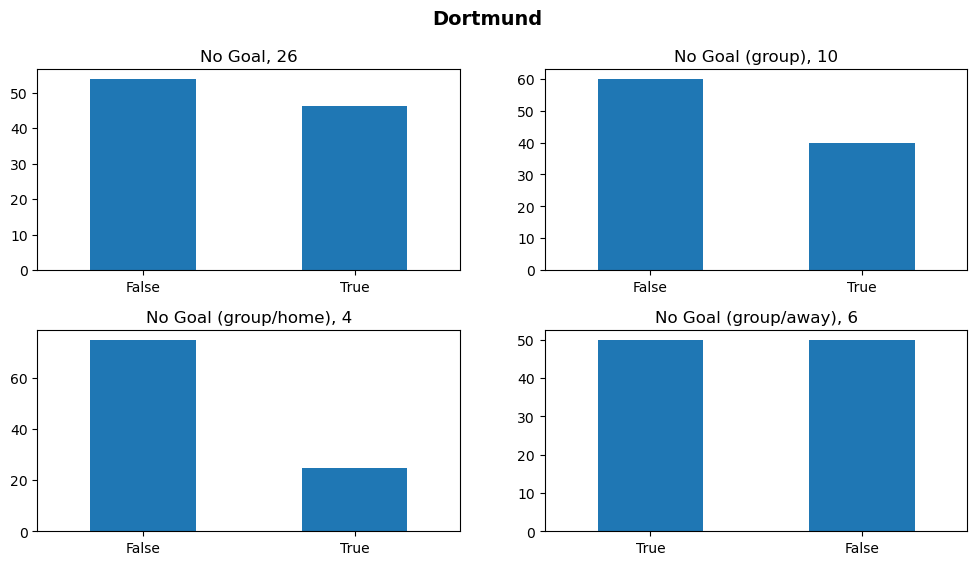

In [1368]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle(f"{away_team}", fontsize=14, fontweight='bold')

(team_away_df.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal, {len(team_away_df)}', ax=axes[0][0], rot=0)
(team_away_df_grp.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
(team_away_df_grp[team_away_df_grp.type=='home'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_away_df_grp[team_away_df_grp.type=='away'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

In [1369]:
team_away_df.merge(standing, left_on='opponent_team', right_on='team_short_name')

,main_team,opponent_team,goal_fatti,no_goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
0,Dortmund,Leverkusen,1,True,1,0,home,Win,True,1.0,...,"W,W,W,W,D",12,4,10,40,48,40,8,Leverkusen,0
1,Dortmund,Leverkusen,2,True,2,0,away,Win,True,18.0,...,"W,W,W,W,D",12,4,10,40,48,40,8,Leverkusen,0
2,Dortmund,Werder Bremen,2,False,5,3,home,Loss,True,3.0,...,"L,D,L,L,W",9,4,13,31,40,50,-10,Werder Bremen,1
3,Dortmund,Werder Bremen,2,True,2,0,away,Win,True,20.0,...,"L,D,L,L,W",9,4,13,31,40,50,-10,Werder Bremen,1
4,Dortmund,Hoffenheim,1,True,1,0,home,Win,True,5.0,...,"W,W,L,L,L",7,4,15,25,35,46,-11,Hoffenheim,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,Dortmund,Union Berlin,0,True,2,2,away,Loss,False,10.0,...,"W,W,D,D,L",15,6,5,51,41,28,13,Union Berlin,0
22,Dortmund,Ein Frankfurt,2,False,3,1,away,Win,True,12.0,...,"D,L,D,D,L",11,8,7,41,47,37,10,Ein Frankfurt,0
23,Dortmund,Wolfsburg,0,True,2,2,away,Loss,False,14.0,...,"D,W,D,D,W",10,9,7,39,46,34,12,Wolfsburg,1
24,Dortmund,M'gladbach,2,False,6,4,away,Loss,True,15.0,...,"D,D,L,D,L",8,8,10,32,40,44,-4,M'gladbach,1


##### N° Goals

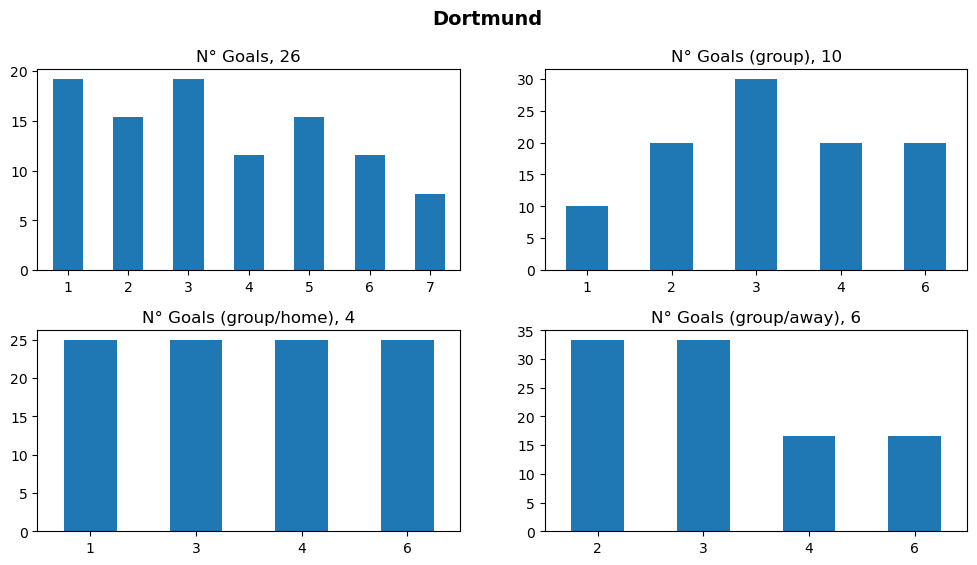

In [1370]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle(f"{away_team}", fontsize=14, fontweight='bold')

(team_away_df['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals, {len(team_away_df)}', ax=axes[0][0], rot=0)
(team_away_df_grp['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
(team_away_df_grp[team_away_df_grp.type=='home']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_away_df_grp[team_away_df_grp.type=='away']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Has Scored

<Axes: title={'center': 'Has scored (grp/away), 6'}>

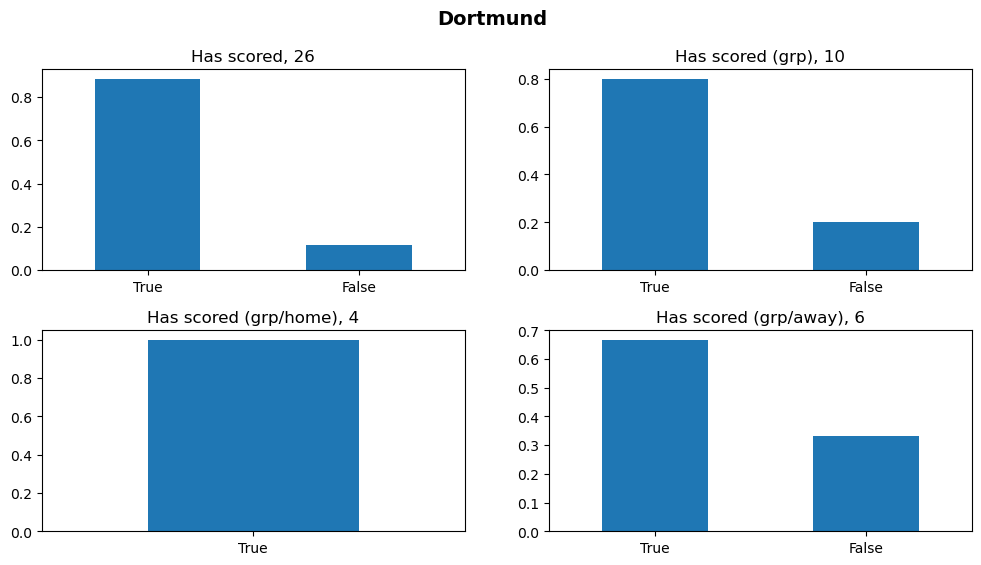

In [1371]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle(f"{away_team}", fontsize=14, fontweight='bold')

team_away_df.team_has_scored.value_counts(normalize=True).plot(kind='bar', title=f'Has scored, {len(team_away_df)}', ax=axes[0][0], rot=0)
team_away_df_grp.team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has scored (grp), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
team_away_df_grp[team_away_df_grp.type=='home'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has scored (grp/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
team_away_df_grp[team_away_df_grp.type=='away'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has scored (grp/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)


##### Result

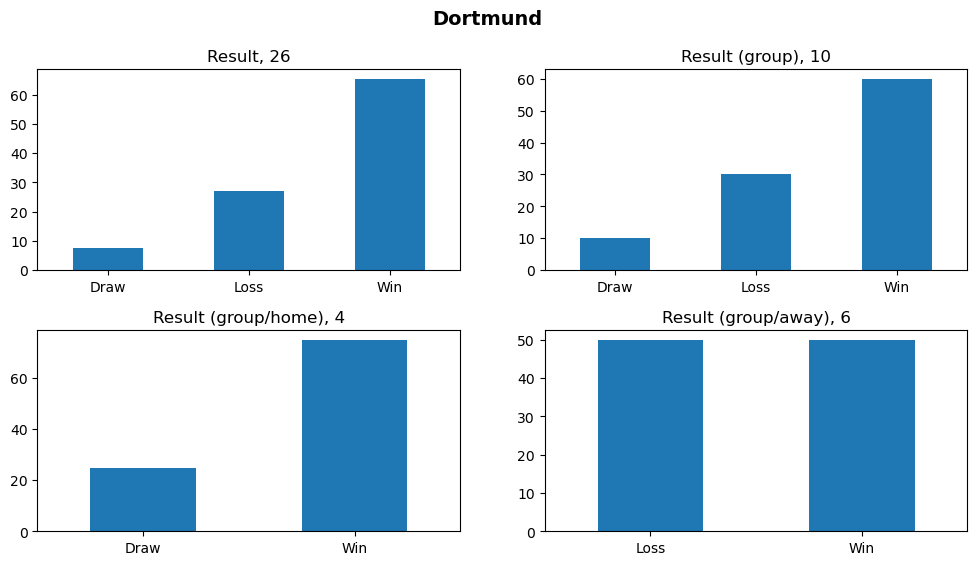

In [1372]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle(f"{away_team}", fontsize=14, fontweight='bold')

(team_away_df['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result, {len(team_away_df)}', ax=axes[0][0], rot=0)
(team_away_df_grp['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result (group), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
(team_away_df_grp[team_away_df_grp.type=='home']['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result (group/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_away_df_grp[team_away_df_grp.type=='away']['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result (group/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Result Trend

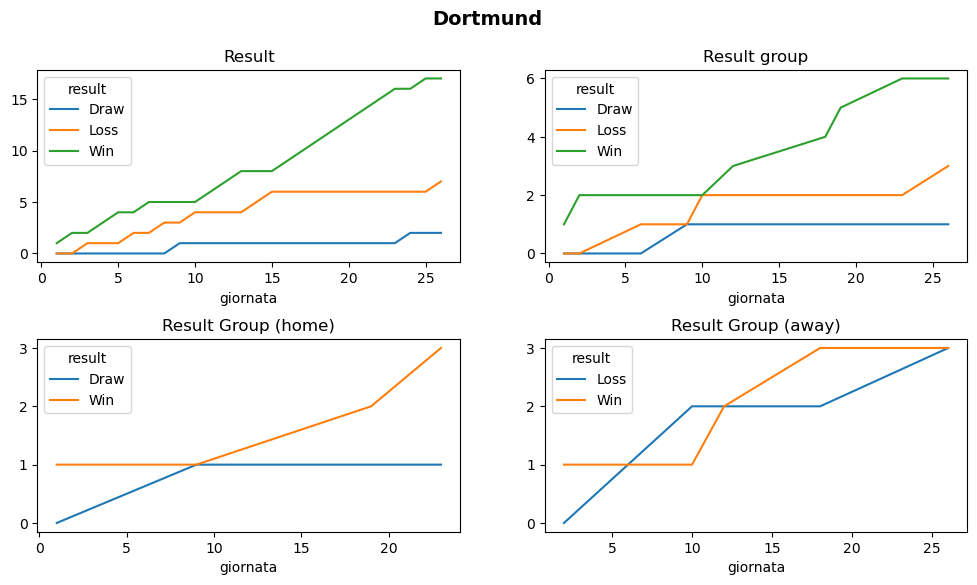

In [1373]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"{away_team}", fontsize=14, fontweight='bold')

team_away_df_grp['value'] = 1
team_away_df['value'] = 1
team_away_df[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result", ax=axes[0][0], rot=0)
team_away_df_grp[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result group", ax=axes[0][1], rot=0)
team_away_df_grp[team_away_df_grp.type=='home'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (home)", ax=axes[1][0], rot=0)
team_away_df_grp[team_away_df_grp.type=='away'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (away)", ax=axes[1][1], rot=0)
plt.show()

### Number of Goals

<Axes: title={'center': 'Inter'}, xlabel='row_num', ylabel='goal_subiti'>

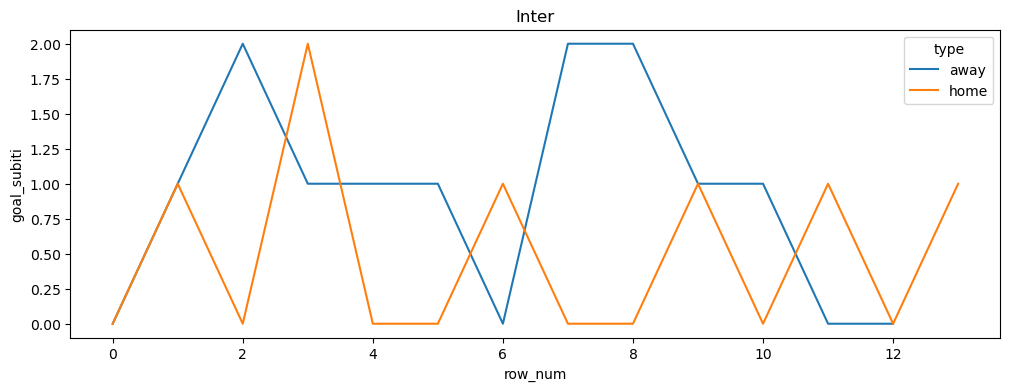

In [1053]:
df_tt = pd.concat([home_sm, away_sm])
df_tt['row_num'] = df_tt.groupby('type').cumcount()
field = 'goal_subiti'
df_tt.pivot(index='row_num',columns='type',values=field).plot(kind='line', figsize=(12,4), title=team, ylabel=field)

<Axes: title={'center': 'Inter'}, xlabel='row_num', ylabel='goal_fatti'>

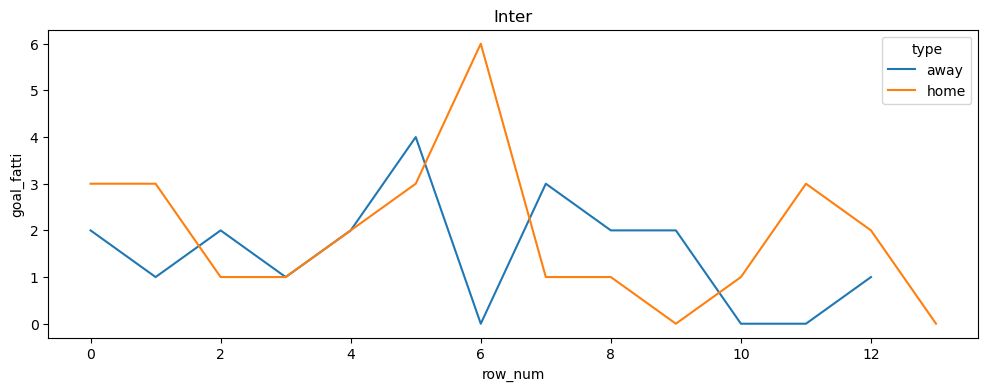

In [59]:
df_tt = pd.concat([home_sm, away_sm])
df_tt['row_num'] = df_tt.groupby('type').cumcount()
field = 'goal_fatti'
df_tt.pivot(index='row_num',columns='type',values=field).plot(kind='line', figsize=(12,4), title=team, ylabel=field)